<a href="https://colab.research.google.com/github/vpste1/mlscrapbook/blob/master/PetBreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 194kB 15.7MB/s 
     |████████████████████████████████| 1.1MB 20.9MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [6]:
(path/"images").ls()

(#7393) [Path('images/beagle_33.jpg'),Path('images/Birman_154.jpg'),Path('images/Russian_Blue_120.jpg'),Path('images/great_pyrenees_109.jpg'),Path('images/american_pit_bull_terrier_94.jpg'),Path('images/american_pit_bull_terrier_160.jpg'),Path('images/great_pyrenees_39.jpg'),Path('images/British_Shorthair_84.jpg'),Path('images/samoyed_82.jpg'),Path('images/leonberger_47.jpg')...]

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

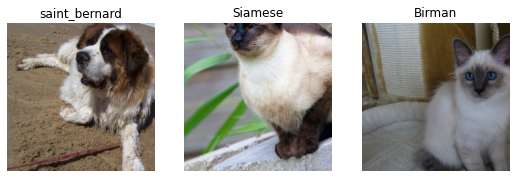

In [8]:
dls.show_batch(nrows=1, ncols=3)

In order to valdiate any mistakes in your `DataBlock` you can run the `summary` method. It will attempt to create a batch from the source you give it (the dataloader below is missing item transforms):

In [ ]:
bad_pets_block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
bad_pets_block.summary(path/"images")

As soon as your data is looking right, it's good to jump in to a preliminary training of your model to implement a few checks. Below trains our original `DataLoaders` for 2 epochs using the `resnet34` pretrained model (transfer learning again).

In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.500684,0.343683,0.112314,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.496247,0.312809,0.094046,01:21
1,0.308413,0.232545,0.076455,01:20


In the MNIST Loss example, we made use of a simple loss function; its core was mapping a prediction to a sigmoid function to tell if something was more a "3" (1) or a "7" (0). 

When moving away from a binary classification, we need a better way of predicting with multiple categories, and subsequently a better loss function to improve those predictions.

**Cross-Entropy Loss** is:

- Faster and more reliable in training
- Can be used when the dependant variable has more than 2 categories

Let's take a look at the activations of our model. To actually get a batch of real data from our `DataLoaders`, we can use the `one_batch` method:

In [11]:
x,y = dls.one_batch()

When we look at our dependant variable, we see a list of integers; each a number between 0 and 36, representing one of the 37 different pet breeds:

In [12]:
 y

TensorCategory([14, 18,  0, 25,  8, 10,  0, 13, 20, 18, 12,  2, 26,  1,  7, 24,  7, 12,  6,  5,  3,  0,  6, 25, 32, 14, 13, 33, 28, 24, 29, 24,  6, 35, 34, 12,  9, 18,  8, 21, 36,  3,  1, 29,  4, 34,  1, 26,
        10,  4,  0, 32, 27, 27,  6,  2,  4, 11,  7, 12, 28,  6, 26, 19], device='cuda:0')

The predictions from our classification model are 37 different probabilities between 0 and 1, and add up to 1 in total:

In [13]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.0294e-07, 9.5814e-08, 6.4903e-09, 2.2669e-09, 2.0174e-08, 7.6944e-08, 2.2788e-09, 7.2893e-09, 1.3057e-09, 1.8413e-08, 7.9892e-10, 1.7704e-09, 4.5787e-08, 1.3439e-07, 9.9999e-01, 8.7012e-06,
        1.2726e-06, 2.1340e-09, 8.4085e-07, 4.2935e-08, 2.1170e-06, 4.8493e-08, 9.7135e-09, 3.6743e-09, 2.0062e-08, 3.8814e-08, 1.0853e-07, 8.7567e-08, 3.6874e-10, 2.9150e-09, 6.5451e-07, 2.4624e-08,
        4.2399e-09, 1.1951e-09, 3.5759e-07, 2.8735e-08, 7.4012e-09])

Transforming our activations from the model into predictions like this is done using **softmax** activation function. Taking a step back to a binary classifier can help in explaining to bridge between our previously used sigmoid function and softmax.

If we have 6 images with 2 possible categories (akin to 3 vs 7 MNIST), and generate a random set of activations (outputs from one layer) like so: 

In [14]:
#hide
torch.random.manual_seed(42);

In [15]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

The sigmoid of this activation directly gives us the relative confidence between 0 and 1 of whether it was one image or the other. But these individual rows wouldn't add up to 1:

In [16]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

We can take the difference between the activations (as that reflects how confident we are of a 3 vs a 7) and take the sigmoid of that relative value:

In [17]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The second column would now  just be that value subtracted from 1. The softmax function performs this same method when there are more than 2 columns:

``` python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

In [18]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

An example may be an array of activations for bear types like so: 

```[0.02, -2.49, 1.25]```

The exponent of them would be:

```[1.02, 0.08, 3.49]```

The sum of the exponent would be ```4.60```, so the relative probabilities would be represented as an array like:

```0.22, 0.02, 0.76``` summing to ```1.00```. 

In the binary case above for the first activation set of ```[0.6734, 0.2576]``` it would look like so:

```a = e**0.6734, b = e**0.2576```

With the softmax output being:

```[a/(a+b), b/(a+b)]```

Previously in our binary classifier, we attributed the probablity of it not being what we wanted as the loss. When there are more categories, the loss can be considered the confidence in it not being the target. 

Once we have all our confidence represented via softmax; we can say the loss is our confidence of our target subracted from 1. 

Whilst this on its own would suffice as a loss function, it's not good at differentiating 0.999 from 0.99 despite there being a 10x confidence difference. Ideally we would stretch this 0->1 to -inf->inf, and can do with log.